In [1]:
# ANALISI SHAP DATASET DI TEST TOTALE, VISUALIZZAZIONE DIVISA PER IMPATTO SU CLASSE 0 E 1


In [2]:
import torch
from transformers import AutoTokenizer

import shap
import nltk
import pickle
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from error_analysis_TRC import load_local_model
from TRC.utils import create_token_dict, get_top_n, load_local_TRC_model


from better_profanity import profanity
from copy import deepcopy
from ast import literal_eval

In [4]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'cardiffnlp/twitter-roberta-large-2022-154m'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_TRC_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# come input prende una lista di tweet
def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [7]:
explainer = shap.Explainer(f, masker = tokenizer)
explainer

In [9]:
df_errati = pd.read_csv('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_errati.csv', index_col = 0, converters={'Tweet tok':literal_eval})
df_corretti = pd.read_csv('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/tweet_corretti.csv', index_col=0,  converters={'Tweet tok':literal_eval})
df_total = pd.concat([df_errati, df_corretti])

In [58]:
# df_total.head()

In [11]:
# df_pred_1 = df_total[(df_total['Pred label'] == 1 )]
# df_pred_1 = df_pred_1.reset_index()
# df_pred_0 = df_total[(df_total['Pred label'] == 0 )]
# df_pred_0 = df_pred_0.reset_index()

In [12]:
# tweet_pred_1 = df_pred_1['Tweet'].values.tolist()
# tweet_pred_0 = df_pred_0['Tweet'].values.tolist()

In [13]:
# tokens_pred_1 = df_pred_1['Tweet tok'].tolist()
# tokens_pred_0 = df_pred_0['Tweet tok'].tolist()

In [14]:
def clean_strings(big_tokens_list):
    tags = ['@USER','USER', 'HTTPURL', 'HTTP', 'URL']
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    clean_list = []
    for t_list in big_tokens_list:
        tokens = deepcopy(t_list)
        for token, i in zip(t_list, range(len(t_list))):
            tmp = deepcopy(token)
            tmp = tmp.strip()
            tmp = tmp.lower()
            if tmp in string.punctuation or \
            tmp.upper() in tags or \
            tmp == '...' or  tmp == '....' or \
            tmp in stop_words or \
            profanity.contains_profanity(tmp) or \
            len(tmp) < 3:
                tokens.remove(token)
        clean_list.append(' '.join(tokens))
    return clean_list
        

In [13]:
# clean_pred_1 = clean_strings(tokens_pred_1)
# clean_pred_0 = clean_strings(tokens_pred_0)

In [14]:
# SHAP FOR ALL DS

In [15]:
# all_tweets = df_total['Tweet'].tolist()
all_tweets_tokens = df_total['Tweet tok'].tolist()

In [16]:
cleaned_all = clean_strings(all_tweets_tokens)
cleaned_all[:5]

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# CREAZIONE SHAP_VALUES E SALVATAGGIO IN PICKLE


# save_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/'
# shap_values = explainer(cleaned_all)
# print(shap_values.shape)
# print(shap_values.output_names)
# with open(save_path + 'shap_values_all_test.pickle', 'wb') as handle:
#     pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# LETTURA DA FILE PICKLE SHAP_VALUES SALVATI 

save_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/'
with open(save_path + 'shap_values_all_test.pickle', 'rb') as handle:
    shap_values_loaded = pickle.load(handle)

In [18]:
def token_dict(shap_values):
    token_dict_pos = {}
    token_dict_neg = {}
    nltk.download('stopwords')
    profanity.load_censor_words()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    val = [shap_values[i] for i in range(len(shap_values))]
    for el in val:
        for i in range(len(el)-1):
            token = el[i].data
            token = token.strip()
            if token not in string.punctuation and token != 'USER' and token != 'HTTPURL' and token != 'HTTP' and token!='URL' and token != '...' and len(token) >= 3:
                shap_val = el[i].values
                # pos = abs(shap_val[0])
                # neg = abs(shap_val[1])
                pos = shap_val[1]
                neg = shap_val[0]
                token = token.lower()
                if token not in stop_words:
                    if not profanity.contains_profanity(token):
                        if (token not in token_dict_pos.keys()) or (token not in token_dict_neg.keys()):
                            token_dict_pos[token] = pos
                            token_dict_neg[token] = neg
                        else:
                            token_dict_pos[token] += pos
                            token_dict_neg[token] += neg
                            
    return token_dict_pos, token_dict_neg

In [19]:
token_dict_pos, token_dict_neg = token_dict(shap_values_loaded)

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
sorted_pos = sorted(token_dict_pos.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_pos = dict(sorted_pos)

sorted_neg = sorted(token_dict_neg.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_neg = dict(sorted_neg)

In [ ]:
# PLOT FOR CLASS 1

In [21]:
to_plot_pos = get_top_n(20,sorted_d_pos)

In [22]:
def colors(x):
    colorsValue = []
    for value in x.values():
        if value < 0:
            colorsValue.append('darkturquoise')
        elif value >= 0:
            colorsValue.append('orange')
    return colorsValue

In [23]:
colors_list = colors(to_plot_pos)

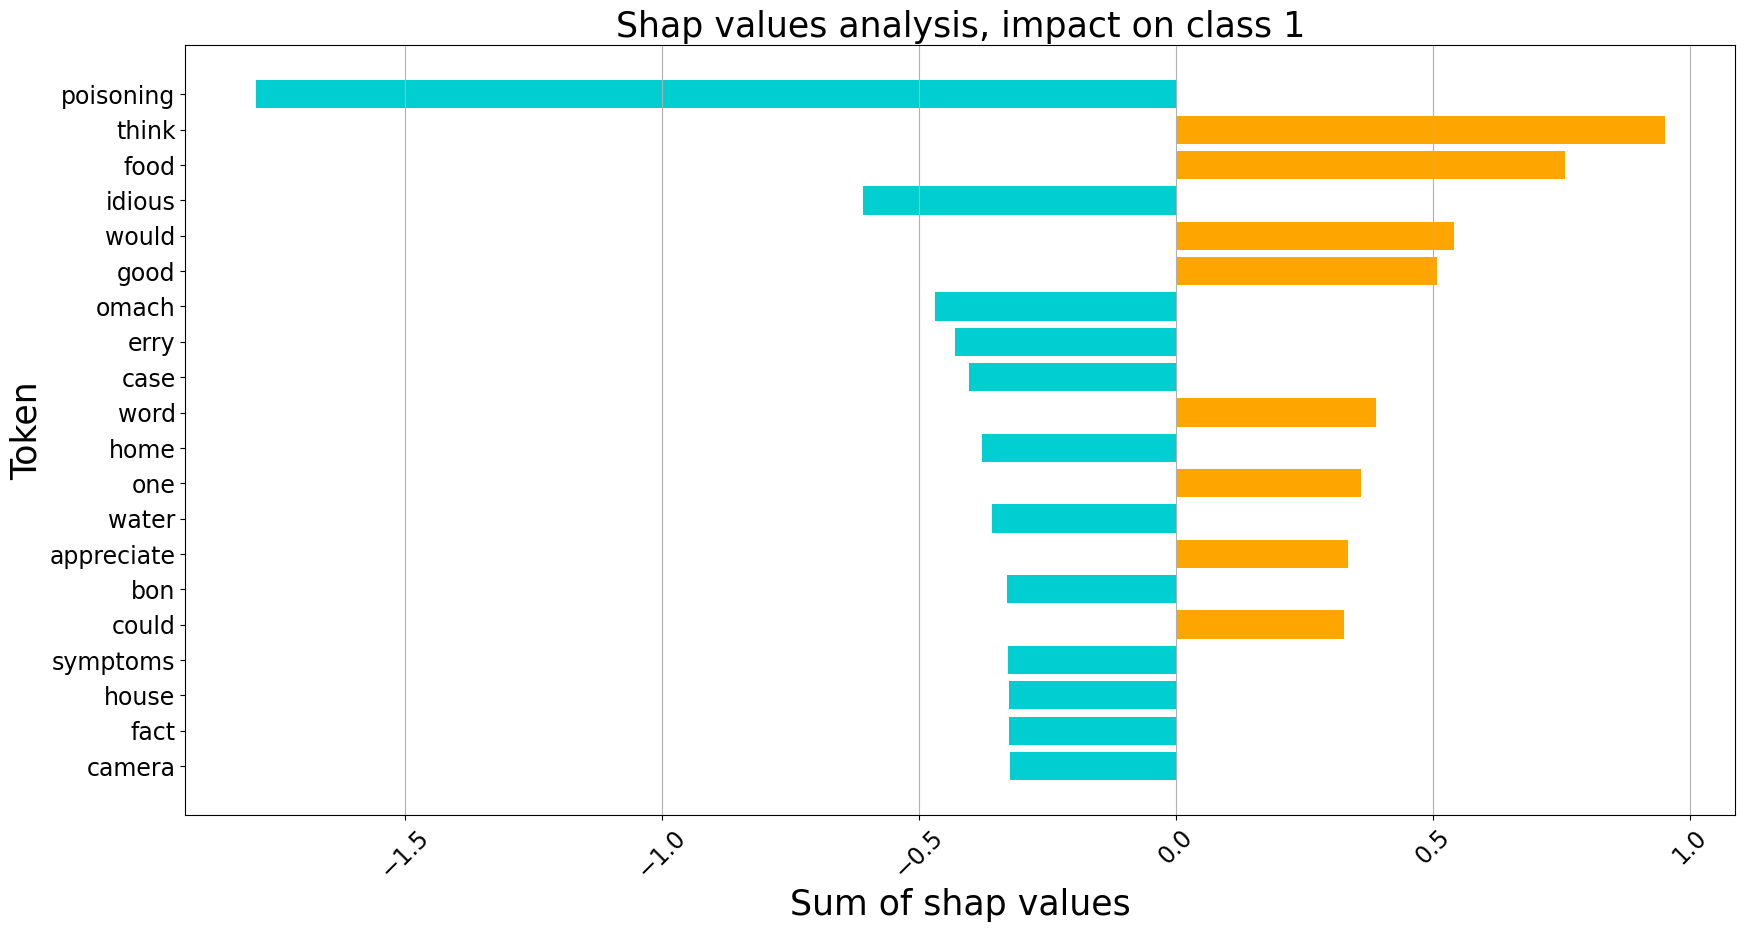

In [24]:
# IMPACT ON CLASS 1

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_pos)), list(to_plot_pos.values()), tick_label=list(to_plot_pos.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 1', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


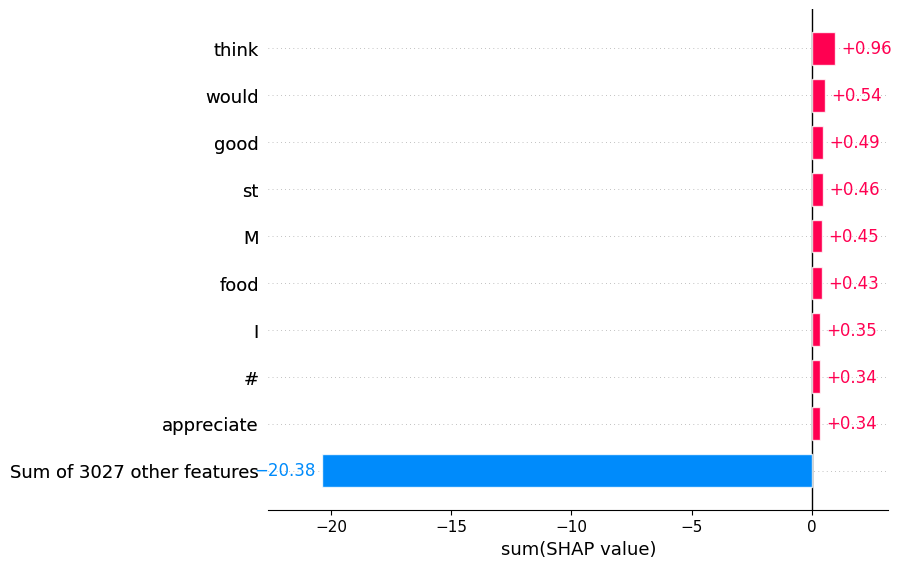

In [25]:
shap.plots.bar(shap_values_loaded[:,:,1].sum(0), order=shap.Explanation.argsort.flip)

In [21]:
# PLOT FOR CLASS 0

In [26]:
to_plot_neg = get_top_n(20, sorted_d_neg)

In [27]:
colors_list = colors(to_plot_neg)

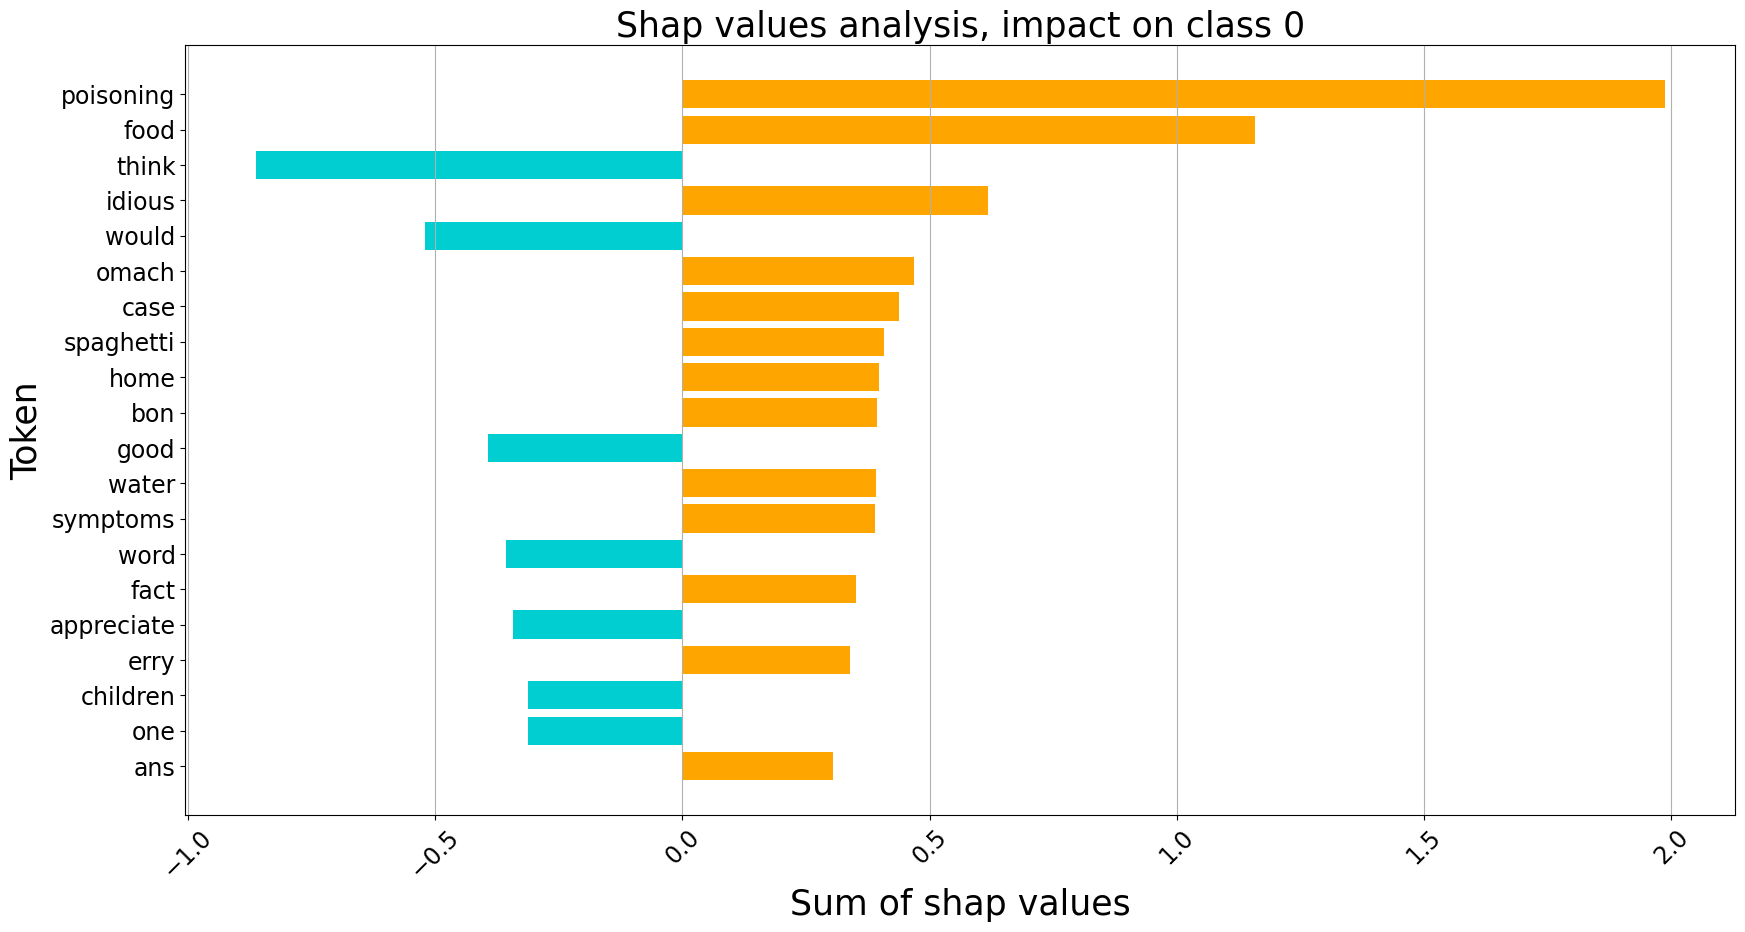

In [28]:
# IMPACT ON CLASS 0

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_neg)), list(to_plot_neg.values()), tick_label=list(to_plot_neg.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 0', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


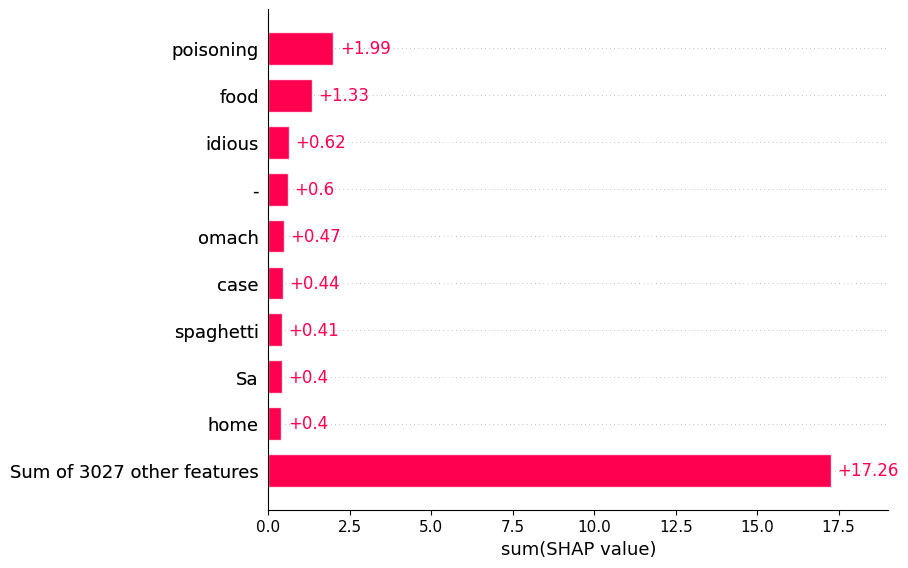

In [29]:
shap.plots.bar(shap_values_loaded[:,:,0].sum(0),  order=shap.Explanation.argsort.flip)

In [ ]:
### PROVA CON FRASI RANDOM ABOUT FOOD

In [28]:
food_0 = pd.read_csv('/home/cc/rora_tesi_new/food_0.csv')
food_0.head()

,Phrase,Sentence_class
0,Delicious food awaits at the new restaurant in...,0
1,Exploring different cuisines is an adventure f...,0
2,Food is not just sustenance; it's an art form.,0
3,Comfort food brings warmth to the soul on a ra...,0
4,Trying exotic food can be a memorable experience.,0


In [44]:
food_0_list = food_0['Phrase'].values.tolist()

In [55]:
logits = f(food_0_list)

In [50]:
import torch.nn as nn

In [51]:
m = nn.Softmax(dim=1)
probabilities = m(logits)
# torna il valore più alto e il rispettivo indice 
# y_values la probabilità maggiore per ogni tweet
y_values, indices = torch.max(probabilities, 1)

In [53]:
indices

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], device='cuda:0')

In [48]:
logits.argmax()

tensor(8, device='cuda:0')

In [31]:
shap_values = explainer(food_0_list)
shap_values.shape

Partition explainer: 31it [00:59,  2.22s/it]                        


(30, None, 2)

In [57]:
shap_values[0]

.values =
array([[-1.37835741e-07,  2.90572643e-07],
       [-6.71516750e-02,  2.30415277e-02],
       [-2.33021025e-02,  5.80434911e-02],
       [-2.01891866e-02,  4.44558449e-02],
       [ 3.14574335e-02,  1.53097548e-02],
       [ 5.87662496e-03, -8.91152769e-03],
       [ 2.92807259e-03, -4.67813313e-02],
       [-3.44994459e-02, -2.10061446e-02],
       [-1.25822742e-02,  3.94314677e-02],
       [ 1.20645911e-02, -3.38610485e-02],
       [ 4.50541414e-02, -1.40863359e-02],
       [ 2.26448543e-01, -6.62599564e-01],
       [-3.27825546e-07,  5.60283661e-06]])

.base_values =
array([ 0.71819317, -0.71468526])

.data =
array(['', 'Del', 'icious ', 'food ', 'awaits ', 'at ', 'the ', 'new ',
       'restaurant ', 'in ', 'town', '.', ''], dtype='<U11')

In [34]:
token_dict_pos, token_dict_neg = token_dict(shap_values)

[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
sorted_pos = sorted(token_dict_pos.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_pos = dict(sorted_pos)

sorted_neg = sorted(token_dict_neg.items(), key = lambda x:abs(x[1]), reverse = True)
sorted_d_neg = dict(sorted_neg)

In [37]:
to_plot_pos = get_top_n(20,sorted_d_pos)

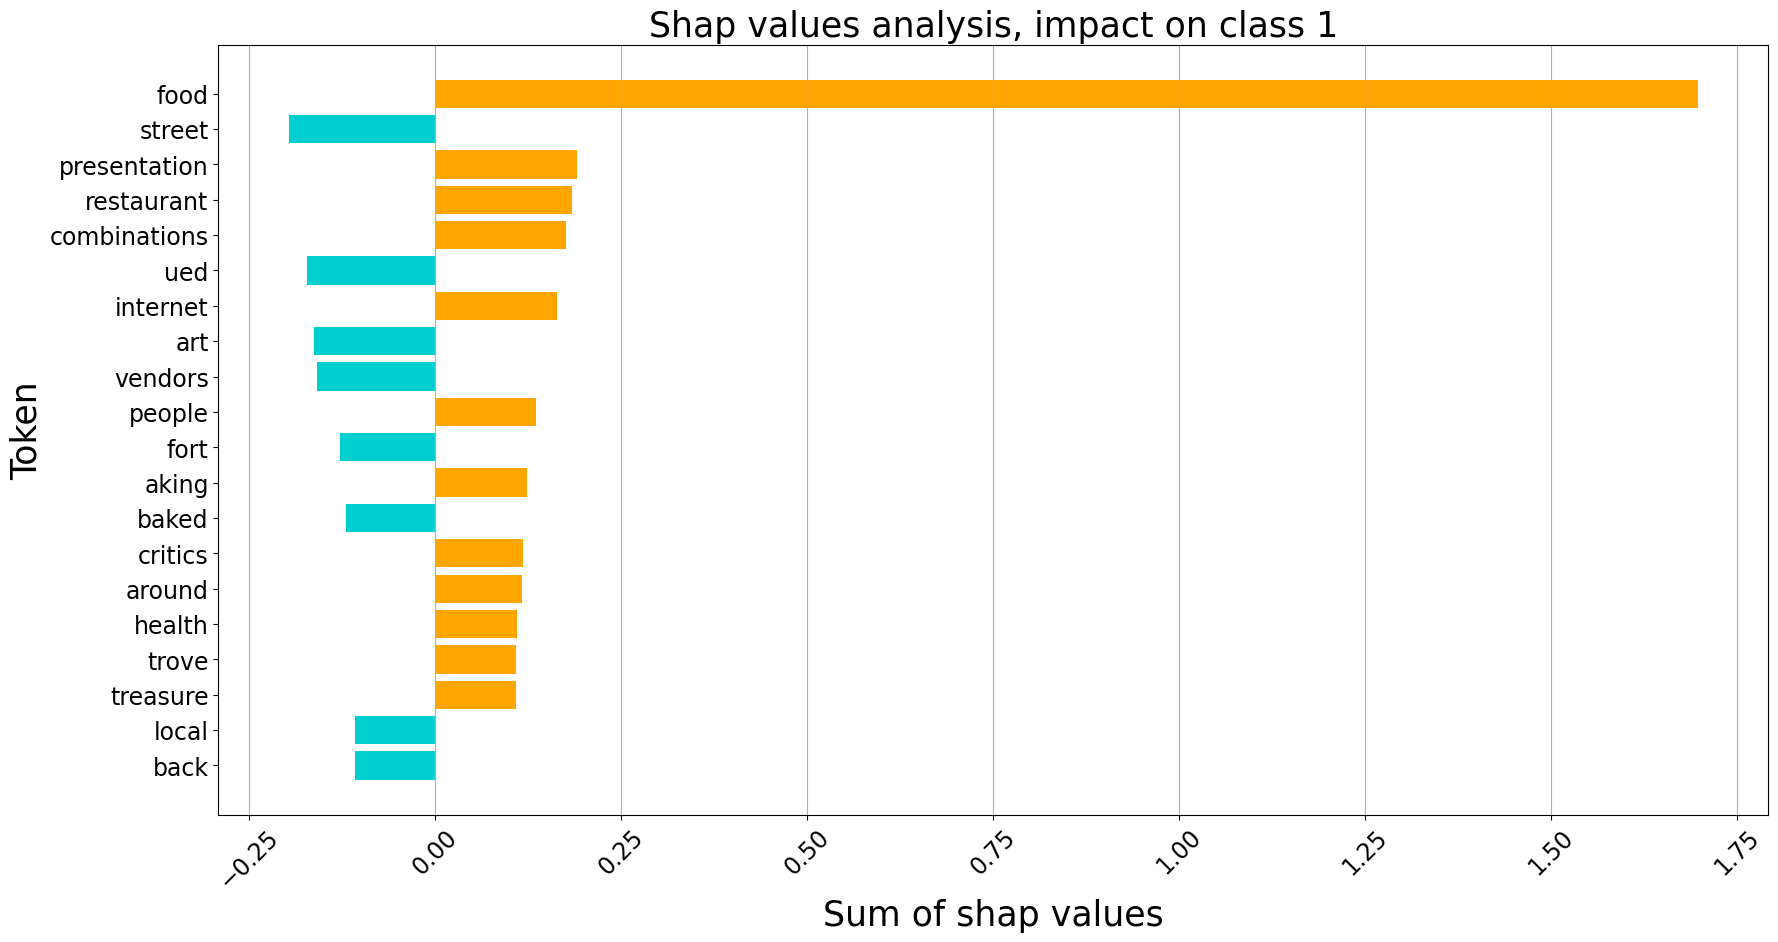

In [39]:
# IMPACT ON CLASS 1

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_pos)), list(to_plot_pos.values()), tick_label=list(to_plot_pos.keys()), color = colors(to_plot_pos))
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 1', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [41]:
to_plot_neg = get_top_n(20,sorted_d_neg)

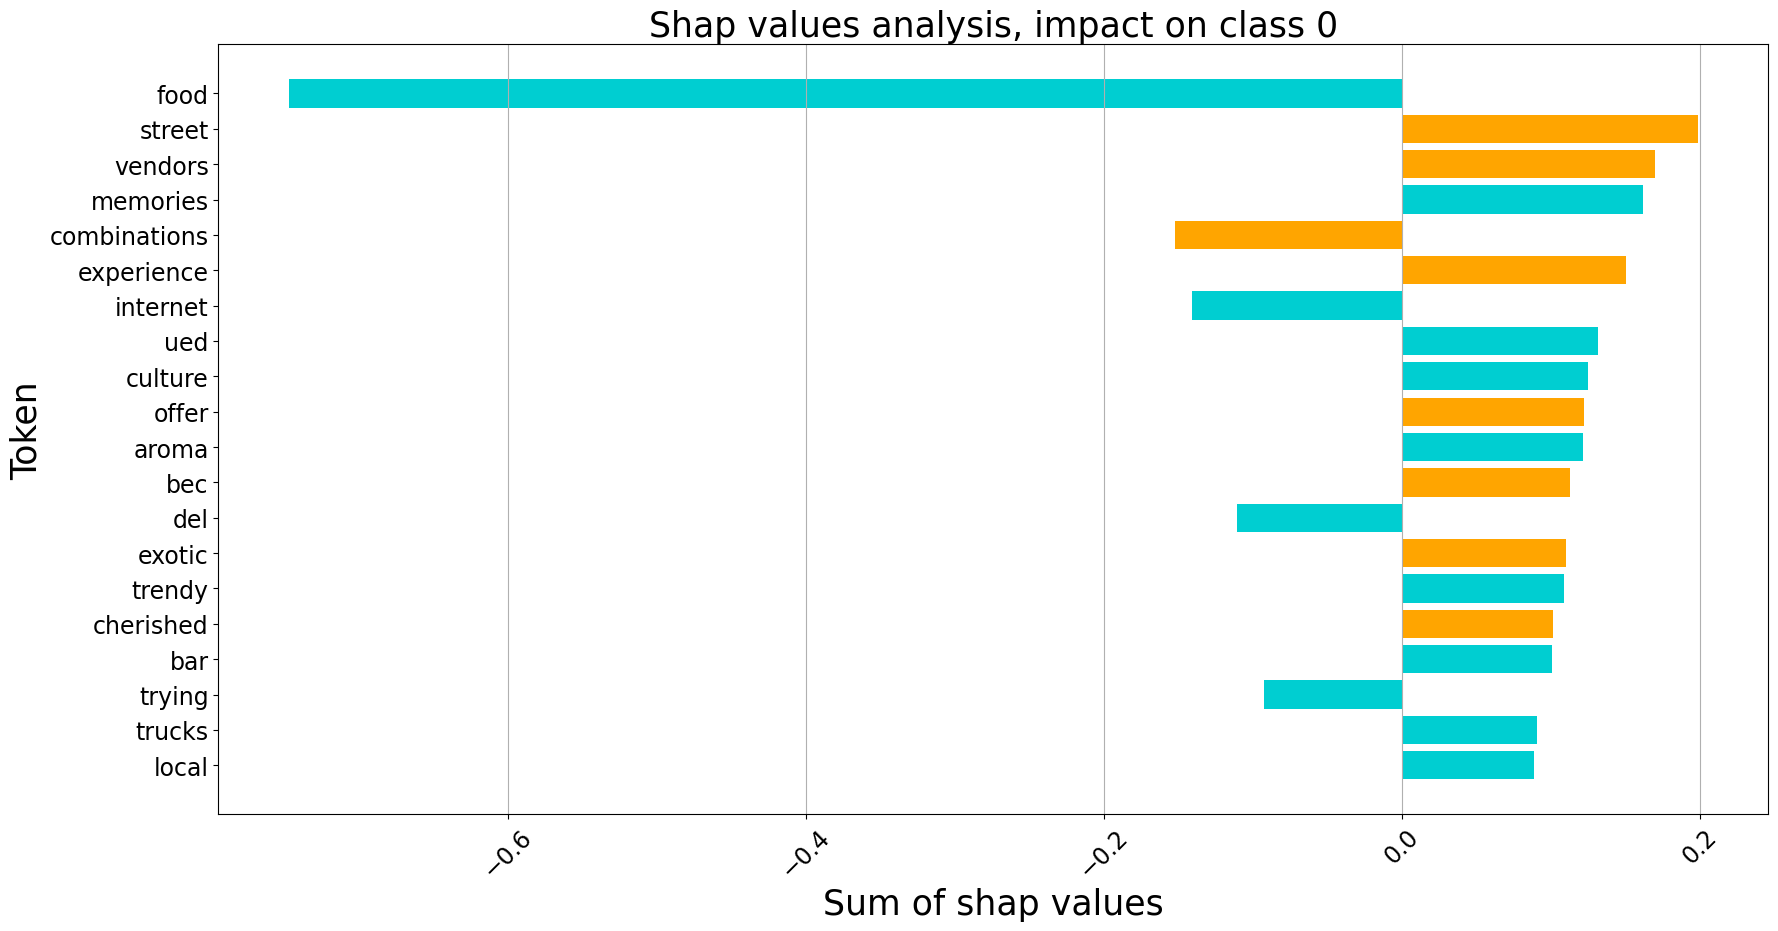

In [42]:
# IMPACT ON CLASS 0

plt.figure(figsize=(20,10))
plt.barh(range(len(to_plot_neg)), list(to_plot_neg.values()), tick_label=list(to_plot_neg.keys()), color = colors_list)
plt.xticks(fontsize=17, rotation = 45)
plt.yticks(fontsize=17)
plt.title('Shap values analysis, impact on class 0', fontsize = 25)
plt.ylabel('Token', fontsize = 25)
plt.xlabel('Sum of shap values', fontsize = 25)
plt.grid(axis = 'x')
plt.gca().invert_yaxis()
# plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
plt.show()

In [ ]:
##############################################

In [88]:
# i = 1

In [106]:
# ft_names = np.unique(np.concatenate(shap_values.feature_names))
# values = shap_values.sum(0).values[:, i]
# print(len(ft_names) == len(values))

True


In [107]:
# res = {ft_names[i]: values[i] for i in range(len(values))}

In [108]:
# filtered_dict = {k: v for k, v in res.items() if (len(k.strip()) > 3 and str(k).isalpha() == True) }

In [109]:
# sorted_filtered_dict = dict(sorted(filtered_dict.items(), key = lambda x:x[1], reverse = True))

In [110]:
# to_plot_pos = get_top_n(30,sorted_filtered_dict)

In [112]:
# # CLASS 1
# plt.figure(figsize=(25,7))
# plt.bar(range(len(to_plot_pos)), list(to_plot_pos.values()), tick_label=list(to_plot_pos.keys()), color = 'green')
# plt.xticks(fontsize=17, rotation = 45)
# plt.yticks(fontsize=17)
# plt.title('Shap values analysis, impact on class 1', fontsize = 25)
# plt.xlabel('Token', fontsize = 25)
# plt.ylabel('Sum of shap values', fontsize = 25)
# plt.grid()
# # plt.savefig('/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/shap/shap_pred_1.png',bbox_inches='tight')
# plt.show()

In [ ]:
##############################################